In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
class Data:
    def __init__(self):
        self.dataframe = pd.DataFrame([])

    def read(self, file_name: str):
        """Reads a CSV file into the dataframe."""
        if os.path.exists(file_name):
            self.dataframe = pd.read_csv(file_name)
            print(f"Data successfully read from {file_name}.")
        else:
            print(f"Error: The file {file_name} does not exist.")

    def check_null_values(self):
        """Checks for null values in the dataframe."""
        print("Null Values Before Cleaning:")
        print(self.dataframe.isnull().sum())

    def clean_data(self):
        """Removes null values from the dataframe."""
        initial_shape = self.dataframe.shape
        self.dataframe.dropna(inplace=True)
        final_shape = self.dataframe.shape
        print(f"Data cleaned: {initial_shape[0] - final_shape[0]} rows removed.")

    def print_head(self):
        """Prints the head of the dataframe."""
        print("Head of the DataFrame:")
        print(self.dataframe.head())

    def print_description(self):
        """Prints the description of the dataframe."""
        print("\nDescription of the DataFrame:")
        print(self.dataframe.describe())

    def normalize(self):
        """Normalizes numeric columns in the dataframe."""
        numeric_cols = self.dataframe.select_dtypes(include=['float64', 'int64']).columns
        self.scaler = MinMaxScaler()
        self.dataframe[numeric_cols] = self.scaler.fit_transform(self.dataframe[numeric_cols])
        print(f"Data normalized for columns: {numeric_cols.tolist()}")

    def visualize_open(self):
        """Plots graph for open stock values vs. date."""
        if 'Date' in self.dataframe.columns and 'Open' in self.dataframe.columns:
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            sns.lineplot(data=self.dataframe, x='Date', y='Open')
            plt.title('Open Stock Values over the Years')
            plt.xlabel('Year')
            plt.ylabel('Open Stock Value')
            plt.show()
        else:
            print(f"Dataframe does not contain 'Date' and 'Open' columns.")

    def visualize_close(self):
        """Plots graph for close stock values vs. data."""
        if 'Date' in self.dataframe.columns and 'Close' in self.dataframe.columns:
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            sns.lineplot(data=self.dataframe, x='Date', y='Close')
            plt.title('Close Stock Values over the Years')
            plt.xlabel('Year')
            plt.ylabel('Close Stock Value')
            plt.show()
        else:
            print(f"Dataframe does not contain 'Date' and 'Close' columns.")


In [ ]:
data = Data()


In [ ]:
data.read('/content/sample_data/ITC.csv')


Data successfully read from /content/sample_data/ITC.csv.


In [ ]:
data.check_null_values()


Null Values Before Cleaning:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
data.clean_data()




Data cleaned: 0 rows removed.


In [ ]:
data.print_head()


Head of the DataFrame:
         Date        Open        High         Low       Close   Adj Close  \
0  2019-05-29  288.799988  291.700012  287.600006  288.100006  239.825165   
1  2019-05-30  289.000000  291.049988  288.299988  288.649994  240.282959   
2  2019-05-31  289.350006  291.500000  277.450012  278.549988  231.875366   
3  2019-06-03  281.399994  281.500000  275.299988  278.549988  231.875366   
4  2019-06-04  279.250000  282.149994  278.799988  279.250000  232.458038   

     Volume  
0   7255516  
1   8656311  
2  26281811  
3  19569620  
4  13850737  


In [ ]:
data.print_description()



Description of the DataFrame:
              Open         High          Low        Close    Adj Close  \
count  1236.000000  1236.000000  1236.000000  1236.000000  1236.000000   
mean    288.908333   291.591343   285.768366   288.535518   269.519708   
std      95.992943    96.394562    95.434650    95.952791   104.504340   
min     148.000000   152.000000   134.600006   147.250000   122.576385   
25%     210.200001   212.300003   207.924999   209.649998   188.941734   
50%     251.349998   253.849998   248.224998   250.399994   217.682274   
75%     378.824990   382.775002   374.250008   378.725006   370.235352   
max     493.450012   499.700012   487.000000   492.149994   485.026489   

             Volume  
count  1.236000e+03  
mean   1.992243e+07  
std    1.583594e+07  
min    3.131726e+06  
25%    9.938729e+06  
50%    1.546288e+07  
75%    2.341236e+07  
max    1.492389e+08  


In [ ]:
data.normalize()


Data normalized for columns: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


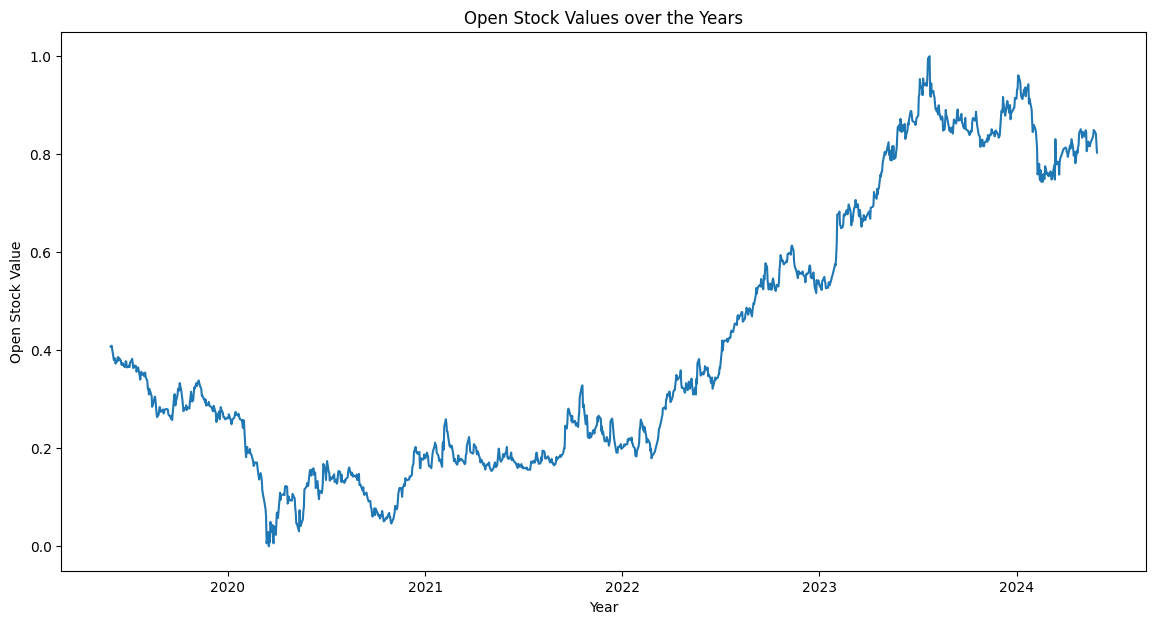

In [ ]:
data.visualize_open()


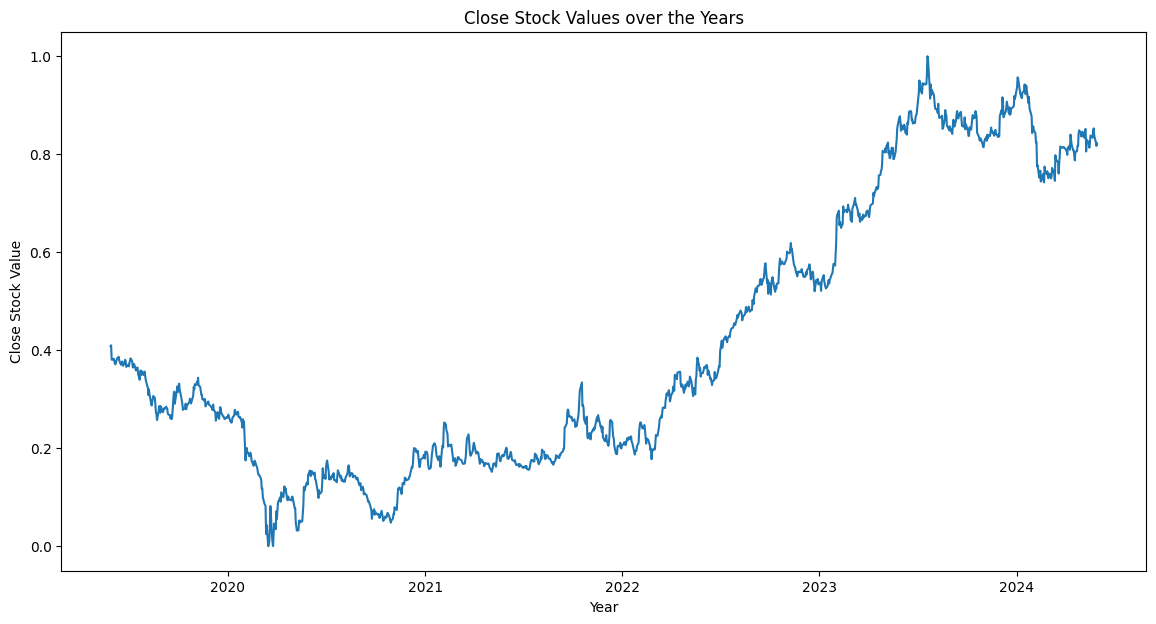

In [ ]:
data.visualize_close()


In [ ]:
class LSTM_Trainer:
    def __init__(self, dataframe, scaler):
        self.dataframe = dataframe
        self.scaler = scaler

    def prepare_data(self, feature_col = 'Close', look_back = 60):
        """Prepare data for lstm"""
        data = self.dataframe[feature_col].values
        data = data.reshape(-1, 1)

        x = []
        y = []

        for i in range(len(data) - look_back):
            x.append(data[i:i + look_back])
            y.append(data[i + look_back])

        x, y = np.array(x), np.array(y)

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = False)
        return x_train, x_test, y_train, y_test.reshape(-1, 1)


    def build_and_train_lstm(self, feature_col = 'Close', look_back = 60, epochs = 50, batch_size = 32):
        """Build and train the lstm model"""
        x_train, x_test, y_train, y_test = self.prepare_data(feature_col, look_back)

        model = Sequential()
        model.add(LSTM(units = 50, return_sequences = True, input_shape = (look_back, 1)))
        model.add(LSTM(units = 50))
        model.add(Dense(1))

        model.compile(optimizer = 'adam', loss = 'mean_squared_error')

        model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, y_test))

        self.model = model
        self.x_test = x_test
        self.y_test = y_test

    def predict_and_plot(self):
        """Make predictions and plot the results"""
        predictions = self.model.predict(self.x_test)
        predictions = predictions.reshape(-1, 1)
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.scaler.fit(self.dataframe['Close'].values.reshape(-1, 1))
        predictions = self.scaler.inverse_transform(predictions)
        actual = self.scaler.inverse_transform(self.y_test.reshape(-1, 1))

        plt.figure(figsize = (14, 7))
        plt.plot(actual, label = 'Actual Stock Price')
        plt.plot(predictions, label = 'Predicted Stock Price')
        plt.title('Actual vs Predicted Stock Prices')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

    def evaluate_model(self):
        """Evaluating the model"""
        predictions = self.model.predict(self.x_test)
        predictions = self.scaler.inverse_transform(predictions)
        actual = self.scaler.inverse_transform(self.y_test.reshape(-1, 1))

        mse = mean_squared_error(actual, predictions)
        mae = mean_absolute_error(actual, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(actual, predictions)

        print(f"Mean Squared Error: {mse}")
        print(f"Mean Absolute Error: {mae}")
        print(f"Root Mean Squared Error: {rmse}")
        print(f"R-squared: {r2}")


In [ ]:
trainer = LSTM_Trainer(data.dataframe, data.scaler)


In [ ]:
trainer.build_and_train_lstm()


Epoch 1/50
30/30 [==============================] - 7s 78ms/step - loss: 0.0179 - val_loss: 0.0020
Epoch 2/50
30/30 [==============================] - 2s 53ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 3/50
30/30 [==============================] - 1s 48ms/step - loss: 7.3848e-04 - val_loss: 0.0016
Epoch 4/50
30/30 [==============================] - 2s 50ms/step - loss: 7.2173e-04 - val_loss: 0.0018
Epoch 5/50
30/30 [==============================] - 3s 87ms/step - loss: 7.0795e-04 - val_loss: 0.0013
Epoch 6/50
30/30 [==============================] - 2s 59ms/step - loss: 7.0162e-04 - val_loss: 0.0018
Epoch 7/50
30/30 [==============================] - 2s 53ms/step - loss: 6.7178e-04 - val_loss: 0.0015
Epoch 8/50
30/30 [==============================] - 2s 55ms/step - loss: 6.3137e-04 - val_loss: 0.0015
Epoch 9/50
30/30 [==============================] - 2s 55ms/step - loss: 6.2479e-04 - val_loss: 8.2324e-04
Epoch 10/50
30/30 [==============================] - 1s 50ms/step - loss: 6.2

8/8 [==============================] - 0s 14ms/step


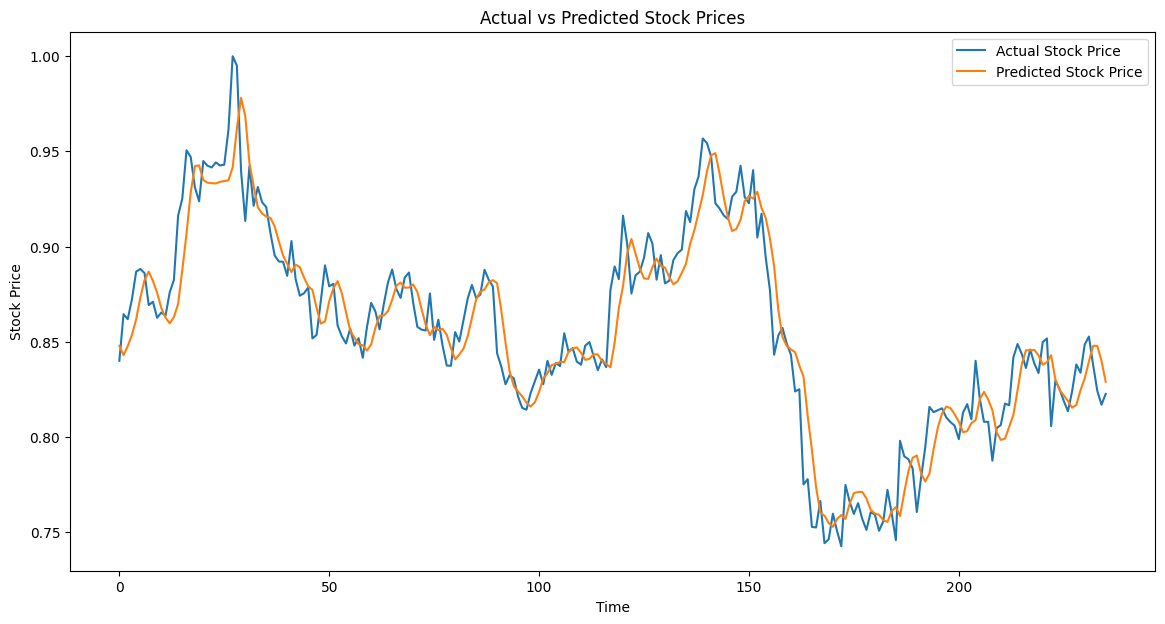

In [ ]:
trainer.predict_and_plot()
